# Load data

In [2]:
import os
import gc
import pandas as pd

import pickle
from collections import Counter
from tqdm import tqdm
import numpy as np
import random

import json
import ast
from sklearn.metrics import *

import matplotlib.pyplot as plt
import seaborn as sns

# Author attributes

In [3]:
with open(f"{os.getcwd()}//data/author_to_controversialIndex_byRedditor.pkl", "rb") as f:
    author_to_testHardIdx = pickle.load(f)
author_cnt = {_author:len(author_to_testHardIdx[_author]) for _author in author_to_testHardIdx}
author_cnt = sorted(author_cnt.items(), key=lambda x:x[1], reverse=True)
AUTHORS = [elem[0] for elem in author_cnt[:100]]

"""
author_to_controversialRatio:
- closer to 0 -> tend to participate on non-controversial situations
- closer to 1 -> tend to participate on more controversial situations
"""
author_to_controversialRatio = {} # 
for _author in author_to_testHardIdx:
    author_to_controversialRatio[_author] = sum(author_to_testHardIdx[_author])/len(author_to_testHardIdx[_author])

In [4]:
"""
author_to_judgmentPatterns:
- closer to 0 -> tend to say 'not acceptable' more
- closer to 1 -> tend to say 'acceptable' more
- closer to 0.5 -> balanced judgment
"""

with open(f"{os.getcwd()}//data/subID_to_votes.pkl", "rb") as f:
    subID_to_votes = pickle.load(f)
with open(f"{os.getcwd()}//data/author_to_subID_to_inst.pkl", "rb") as f:
    author_to_subID_to_inst = pickle.load(f)
    
author_to_judgmentPatterns, author_to_numInst, author_to_numInst_log = {}, {}, {}
for _author in author_to_subID_to_inst:
    _patterns = []
    for _subID in author_to_subID_to_inst[_author]:
        _patterns.append(author_to_subID_to_inst[_author][_subID]['judgment'])
    author_to_judgmentPatterns[_author] = 1-abs(0.5-sum(_patterns)/len(_patterns))*2
    author_to_numInst[_author] = len(_patterns)
    author_to_numInst_log[_author] = np.log(len(_patterns))

In [5]:
"""
author_to_majorityRatio:
- closer to 0 -> tend to align with majority 
- closer to 1 -> tend to be outlier
"""

author_to_majorityRatio = {}
for _author in author_to_subID_to_inst:
    _tendencies = []
    for _subID in author_to_subID_to_inst[_author]:
        _val = sum(subID_to_votes[_subID])/len(subID_to_votes[_subID])
        _majority = round(_val)
        _judgment = author_to_subID_to_inst[_author][_subID]['judgment']
        
        if _majority != _judgment and (_val < 0.3 or _val > 0.7):
            _tendencies.append(1)
        else:
            _tendencies.append(0)

    author_to_majorityRatio[_author] = sum(_tendencies)/len(_tendencies)

In [6]:
author_to_numInst_judgmentPatterns = {}
for _author in author_to_subID_to_inst:
    author_to_numInst_judgmentPatterns[_author] = author_to_numInst_log[_author] * author_to_judgmentPatterns[_author]

In [7]:
from sklearn.preprocessing import QuantileTransformer

def flatten_attr_dict(attr_dict, n_quantiles=10):
    _authors, _list = [], []
    for _author in attr_dict:
        _authors.append(_author)
        _list.append(attr_dict[_author])
    quantile_transformer = QuantileTransformer(output_distribution='uniform', n_quantiles=n_quantiles)
    data = np.array(_list).reshape(-1, 1)
    transformed_data = [elem[0] for elem in quantile_transformer.fit_transform(data)]
    return_dict = {}
    for _author, _mapped_data in zip(_authors, transformed_data):
        return_dict[_author] = _mapped_data
    return return_dict

author_to_numInst_flat = flatten_attr_dict(author_to_numInst)
author_to_majorityRatio_flat = flatten_attr_dict(author_to_majorityRatio)
author_to_controversialRatio_flat = flatten_attr_dict(author_to_controversialRatio)
author_to_judgmentPatterns_flat = flatten_attr_dict(author_to_judgmentPatterns)
author_to_numInst_judgmentPatterns_flat = flatten_attr_dict(author_to_numInst_judgmentPatterns)

In [8]:
# Define user "difficultiness" in a fine-tuned models' view

thrs = [0.1, 0.2, 0.25, 0.3, 0.4, 0.5]
# author_data_sorted = sorted(author_to_numInst_judgmentPatterns.items(), key=lambda x:x[1], reverse=True)
author_data_sorted = sorted(author_to_numInst.items(), key=lambda x:x[1], reverse=True)
author_data_sorted = [elem for elem in author_data_sorted if elem[0] in AUTHORS]
num_authors = len(author_data_sorted)

top_thr_to_authors, bottom_thr_to_authors = {}, {}
for _thr in thrs:
    top_thr_to_authors[_thr] = [elem[0] for elem in author_data_sorted][:int(num_authors*_thr)]
    bottom_thr_to_authors[_thr] = [elem[0] for elem in author_data_sorted[::-1]][:int(num_authors*_thr)]
    

# Batched LLM Results (gpt-4.1)

In [9]:
output_dir = os.getcwd()+'/gpt_inference/gpt-4.1/'
batchfile_dir = os.getcwd()+'/data/gpt-batchfiles/'
strategies = ['Situation', 'Schwartz', 'Value', 'AbstValue', 'Comm-Value', 'RandomAuthor']
inputs =['Comment', 'AbstValue', 'Value', 'Schwartz']
n_trials = 2

In [140]:
def proc_fewshot(text):
    answer_text = text
    answer_text = ' '.join([item.strip() for item in answer_text.split('\n') if item != ''])
    pattern = r'(?:(\d)\s*\[Answer \d\])|(?:\[Answer \d\]\s*(\d))|(?:\[Answer\d\]\s*(\d))'
    match = re.search(pattern, text)

    return match.group(1) or match.group(2) or match.group(3)
    

In [49]:
def convert_pred_to_digit(labels, preds):
    pred_digits = []
    for _label, _pred in zip(labels, preds):
        if _pred.strip().isdigit():
            pred_digits.append(int(_pred.strip()))
        else:
            if '1' in _pred and '0' not in _pred:
                pred_digits.append(1)
            elif '0' in _pred and '1' not in _pred:
                pred_digits.append(0)
            elif 'acceptable' in _pred.lower() and 'unacceptable' not in _pred.lower():
                pred_digits.append(1)
            elif 'unacceptable' in _pred.lower() and 'Acceptable' not in _pred:
                pred_digits.append(0)
            else:
                pred_digits.append(1-_label)
            
    return pred_digits

In [107]:
def return_llm_results_macro(_strategy, _input, target_authors, isHard, mode, is_CoT=False):
    _filename = f"gpt-4.1_5shots_{_strategy}withSelftext_{_input}.jsonl"
    df = pd.read_json(output_dir+_filename, lines=True)
    
    df['author'] = df['custom_id'].apply(lambda x:x.split('-inst_')[0])
    df['trial'] = df['custom_id'].apply(lambda x:int(x.split('_')[-1]))
    df['isHard'] = df['custom_id'].apply(lambda x:author_to_testHardIdx[x.split('-inst_')[0]][int(x.split('-inst_')[-1].split('-trial_')[0])])

    with open(batchfile_dir+_filename.replace(".jsonl", "__gold.pkl"), "rb") as f:
        id_to_gold = pickle.load(f)

    df = df[df['author'].isin(target_authors)]
    if isHard:
        df = df[df['isHard']==1]
    # else:
    #     df = df[df['isHard']==0]

    macro_f1_scores = []
    for i in range(n_trials):
        minidf = df[df['trial']==i]
        
        _golds = minidf['custom_id'].apply(lambda x:id_to_gold[x]).tolist()
        _preds = minidf['response'].apply(lambda x:x['body']['choices'][0]['message']['content'])
        if is_CoT:
            _preds = minidf['response'].apply(lambda x:proc_fewshot(x['body']['choices'][0]['message']['content']))
        _preds = convert_pred_to_digit(_golds, _preds)

        _dict, f1_scores = {}, []
        for _author, _gold, _pred in zip(minidf['author'].tolist(), _golds, _preds):
            if _author not in _dict:
                _dict[_author] = {'p':[], 'g':[]}
            _dict[_author]['p'].append(_pred)
            _dict[_author]['g'].append(_gold)
        
        for _author in _dict:
            f1_scores.append(f1_score(_dict[_author]['g'], _dict[_author]['p'], average='macro'))
        macro_f1_scores.append(np.mean(f1_scores))

    return macro_f1_scores, len(df)/n_trials

In [94]:
def return_llm_results(_strategy, _input, target_authors, isHard, mode):
    _filename = f"gpt-4.1_5shots_{_strategy}withSelftext_{_input}.jsonl"
    df = pd.read_json(output_dir+_filename, lines=True)
    
    df['author'] = df['custom_id'].apply(lambda x:x.split('-inst_')[0])
    df['trial'] = df['custom_id'].apply(lambda x:int(x.split('_')[-1]))
    df['isHard'] = df['custom_id'].apply(lambda x:author_to_testHardIdx[x.split('-inst_')[0]][int(x.split('-inst_')[-1].split('-trial_')[0])])

    with open(batchfile_dir+_filename.replace(".jsonl", "__gold.pkl"), "rb") as f:
        id_to_gold = pickle.load(f)

    df = df[df['author'].isin(target_authors)]
    if isHard:
        df = df[df['isHard']==1]

    macro_f1_scores = []
    for i in range(n_trials):
        minidf = df[df['trial']==i]
        
        _golds = minidf['custom_id'].apply(lambda x:id_to_gold[x]).tolist()
        _preds = minidf['response'].apply(lambda x:x['body']['choices'][0]['message']['content'])
        _preds = convert_pred_to_digit(_golds, _preds)
        
        if mode == 'overall':
            macro_f1_scores.append(f1_score(_golds, _preds, average='macro'))
        
        elif mode == 'minority':
            _dict, f1_scores, num_supports = {}, [], []
            for _author, _gold, _pred in zip(minidf['author'].tolist(), _golds, _preds):
                if _author not in _dict:
                    _dict[_author] = {'p':[], 'g':[]}
                _dict[_author]['p'].append(_pred)
                _dict[_author]['g'].append(_gold)
            
            for _author in _dict:
                try:
                    _f1_dict = classification_report(_dict[_author]['g'], _dict[_author]['p'], target_names=['N','A'], zero_division=0.0, output_dict=True)
                    if _f1_dict['N']['support'] > _f1_dict['A']['support']:
                        f1_scores.append(_f1_dict['A']['f1-score'])
                        num_supports.append(_f1_dict['A']['support'])
                    else:
                        f1_scores.append(_f1_dict['N']['f1-score'])
                        num_supports.append(_f1_dict['N']['support'])
                except:
                    f1_scores.append(1)
                    num_supports.append(len(_dict[_author]['g']))

            weighted_f1_scores = [elem1*elem2 for elem1,elem2 in zip(f1_scores, num_supports)]
            macro_f1_scores.append(sum(weighted_f1_scores)/sum(num_supports))

    return macro_f1_scores, len(df)/n_trials

In [110]:
def print_llm_results(_strategy, _input, is_CoT=False):
    # author_group_names = ['Authors', 'Top 10%', 'Top 20%', 'Top 25%', 'Bot 25%', 'Bot 20%', 'Bot 10%']
    author_group_names = ['Authors', 'Top 25%', 'Top 50%', 'Bot 50%', 'Bot 25%']
    # author_group_names = ['Authors', 'Top 50%', 'Bot 50%',]
    
    author_groups = [
        AUTHORS,
        top_thr_to_authors[0.25], 
        top_thr_to_authors[0.5], 
        bottom_thr_to_authors[0.5],
        bottom_thr_to_authors[0.25],
    ]
    for _group_name, _author_group in zip(author_group_names, author_groups):
        for _h in [False, True]:
            # for _m in ["overall", "minority"]:
            for _m in ["overall"]:
                # _scores, _support = return_llm_results(_strategy, _input, _author_group, _h, _m)
                _scores, _support = return_llm_results_macro(_strategy, _input, _author_group, _h, _m, is_CoT=is_CoT)
                _mean = np.mean(_scores)
                _std = np.std(_scores)
                # print(f"[{_group_name}]\t[Strategy] {_strategy}\t[Input] {_input}\t[isHard] {_h}\t[Metric] {_m}\t{_mean:.4f} +/- {1.96*_std/np.sqrt(n_trials):.4f}")
                print(f"[{_group_name}]\t[isHard] {_h}\t{_mean:.4f} +/- {1.96*_std/np.sqrt(n_trials):.4f}\t(Support) {int(_support)}")

Retrieval strategy: Situation (baseline)
- Input  
  - Comment
  - Comment + Value  
  - Comment + Abst Value  
  - Comment + Schwartz

In [188]:
print_llm_results("Situation", 'Comment')

[Authors]	[isHard] False	0.7889 +/- 0.0022	(Support) 11496
[Authors]	[isHard] True	0.7388 +/- 0.0013	(Support) 1244
[Top 25%]	[isHard] False	0.7718 +/- 0.0030	(Support) 7410
[Top 25%]	[isHard] True	0.7189 +/- 0.0039	(Support) 909
[Top 50%]	[isHard] False	0.7820 +/- 0.0027	(Support) 9114
[Top 50%]	[isHard] True	0.7308 +/- 0.0035	(Support) 1041
[Bot 50%]	[isHard] False	0.8161 +/- 0.0002	(Support) 2382
[Bot 50%]	[isHard] True	0.7804 +/- 0.0101	(Support) 203
[Bot 25%]	[isHard] False	0.7983 +/- 0.0010	(Support) 1105
[Bot 25%]	[isHard] True	0.8089 +/- 0.0000	(Support) 96


In [172]:
print_llm_results("Situation", 'Comment') # macro

[Authors]	[isHard] False	0.7912 +/- 0.0006	(Support) 11496
[Authors]	[isHard] True	0.7861 +/- 0.0017	(Support) 1244
[Top 25%]	[isHard] False	0.7699 +/- 0.0020	(Support) 7410
[Top 25%]	[isHard] True	0.7508 +/- 0.0018	(Support) 909
[Top 50%]	[isHard] False	0.7858 +/- 0.0041	(Support) 9114
[Top 50%]	[isHard] True	0.8048 +/- 0.0009	(Support) 1041
[Bot 50%]	[isHard] False	0.7966 +/- 0.0030	(Support) 2382
[Bot 50%]	[isHard] True	0.7653 +/- 0.0046	(Support) 203
[Bot 25%]	[isHard] False	0.7848 +/- 0.0036	(Support) 1105
[Bot 25%]	[isHard] True	0.7501 +/- 0.0000	(Support) 96


In [111]:
print_llm_results("Situation", 'Comment_CoT', is_CoT=True) #macro

[Authors]	[isHard] False	0.7976 +/- 0.0017	(Support) 11496
[Authors]	[isHard] True	0.8022 +/- 0.0057	(Support) 1244
[Top 25%]	[isHard] False	0.7719 +/- 0.0029	(Support) 7410
[Top 25%]	[isHard] True	0.7624 +/- 0.0369	(Support) 909
[Top 50%]	[isHard] False	0.7821 +/- 0.0030	(Support) 9114
[Top 50%]	[isHard] True	0.8214 +/- 0.0164	(Support) 1041
[Bot 50%]	[isHard] False	0.8132 +/- 0.0063	(Support) 2382
[Bot 50%]	[isHard] True	0.7809 +/- 0.0062	(Support) 203
[Bot 25%]	[isHard] False	0.8078 +/- 0.0056	(Support) 1105
[Bot 25%]	[isHard] True	0.7802 +/- 0.0305	(Support) 96


In [189]:
print_llm_results("Situation", 'Comment_Value')

[Authors]	[isHard] False	0.7921 +/- 0.0003	(Support) 11496
[Authors]	[isHard] True	0.7465 +/- 0.0016	(Support) 1244
[Top 25%]	[isHard] False	0.7747 +/- 0.0007	(Support) 7410
[Top 25%]	[isHard] True	0.7240 +/- 0.0010	(Support) 909
[Top 50%]	[isHard] False	0.7840 +/- 0.0000	(Support) 9114
[Top 50%]	[isHard] True	0.7359 +/- 0.0019	(Support) 1041
[Bot 50%]	[isHard] False	0.8236 +/- 0.0011	(Support) 2382
[Bot 50%]	[isHard] True	0.8019 +/- 0.0000	(Support) 203
[Bot 25%]	[isHard] False	0.8032 +/- 0.0003	(Support) 1105
[Bot 25%]	[isHard] True	0.8344 +/- 0.0000	(Support) 96


In [173]:
print_llm_results("Situation", 'Comment_Value') # macro

[Authors]	[isHard] False	0.7937 +/- 0.0001	(Support) 11496
[Authors]	[isHard] True	0.7910 +/- 0.0012	(Support) 1244
[Top 25%]	[isHard] False	0.7662 +/- 0.0007	(Support) 7410
[Top 25%]	[isHard] True	0.7106 +/- 0.0003	(Support) 909
[Top 50%]	[isHard] False	0.7796 +/- 0.0010	(Support) 9114
[Top 50%]	[isHard] True	0.7786 +/- 0.0024	(Support) 1041
[Bot 50%]	[isHard] False	0.8078 +/- 0.0013	(Support) 2382
[Bot 50%]	[isHard] True	0.8047 +/- 0.0000	(Support) 203
[Bot 25%]	[isHard] False	0.7922 +/- 0.0002	(Support) 1105
[Bot 25%]	[isHard] True	0.7907 +/- 0.0000	(Support) 96


In [190]:
print_llm_results("Situation", 'Comment_AbstValue')

[Authors]	[isHard] False	0.7894 +/- 0.0007	(Support) 11496
[Authors]	[isHard] True	0.7445 +/- 0.0011	(Support) 1244
[Top 25%]	[isHard] False	0.7733 +/- 0.0007	(Support) 7410
[Top 25%]	[isHard] True	0.7262 +/- 0.0007	(Support) 909
[Top 50%]	[isHard] False	0.7827 +/- 0.0004	(Support) 9114
[Top 50%]	[isHard] True	0.7349 +/- 0.0006	(Support) 1041
[Bot 50%]	[isHard] False	0.8158 +/- 0.0016	(Support) 2382
[Bot 50%]	[isHard] True	0.7952 +/- 0.0035	(Support) 203
[Bot 25%]	[isHard] False	0.7979 +/- 0.0007	(Support) 1105
[Bot 25%]	[isHard] True	0.8089 +/- 0.0000	(Support) 96


In [174]:
print_llm_results("Situation", 'Comment_AbstValue') # macro

[Authors]	[isHard] False	0.7928 +/- 0.0006	(Support) 11496
[Authors]	[isHard] True	0.7905 +/- 0.0020	(Support) 1244
[Top 25%]	[isHard] False	0.7705 +/- 0.0000	(Support) 7410
[Top 25%]	[isHard] True	0.7758 +/- 0.0043	(Support) 909
[Top 50%]	[isHard] False	0.7862 +/- 0.0004	(Support) 9114
[Top 50%]	[isHard] True	0.8017 +/- 0.0022	(Support) 1041
[Bot 50%]	[isHard] False	0.7994 +/- 0.0015	(Support) 2382
[Bot 50%]	[isHard] True	0.7780 +/- 0.0019	(Support) 203
[Bot 25%]	[isHard] False	0.7869 +/- 0.0008	(Support) 1105
[Bot 25%]	[isHard] True	0.7501 +/- 0.0000	(Support) 96


In [191]:
print_llm_results("Situation", 'Comment_Schwartz')

[Authors]	[isHard] False	0.7840 +/- 0.0002	(Support) 11496
[Authors]	[isHard] True	0.7309 +/- 0.0009	(Support) 1244
[Top 25%]	[isHard] False	0.7672 +/- 0.0004	(Support) 7410
[Top 25%]	[isHard] True	0.7095 +/- 0.0010	(Support) 909
[Top 50%]	[isHard] False	0.7753 +/- 0.0001	(Support) 9114
[Top 50%]	[isHard] True	0.7209 +/- 0.0001	(Support) 1041
[Bot 50%]	[isHard] False	0.8178 +/- 0.0013	(Support) 2382
[Bot 50%]	[isHard] True	0.7841 +/- 0.0050	(Support) 203
[Bot 25%]	[isHard] False	0.8064 +/- 0.0027	(Support) 1105
[Bot 25%]	[isHard] True	0.8216 +/- 0.0027	(Support) 96


In [175]:
print_llm_results("Situation", 'Comment_Schwartz') # macro

[Authors]	[isHard] False	0.7814 +/- 0.0010	(Support) 11496
[Authors]	[isHard] True	0.7911 +/- 0.0004	(Support) 1244
[Top 25%]	[isHard] False	0.7570 +/- 0.0027	(Support) 7410
[Top 25%]	[isHard] True	0.7541 +/- 0.0025	(Support) 909
[Top 50%]	[isHard] False	0.7653 +/- 0.0010	(Support) 9114
[Top 50%]	[isHard] True	0.7945 +/- 0.0026	(Support) 1041
[Bot 50%]	[isHard] False	0.7974 +/- 0.0029	(Support) 2382
[Bot 50%]	[isHard] True	0.7873 +/- 0.0038	(Support) 203
[Bot 25%]	[isHard] False	0.7948 +/- 0.0047	(Support) 1105
[Bot 25%]	[isHard] True	0.7871 +/- 0.0110	(Support) 96


In [145]:
print_llm_results("RandomAuthor", 'Comment')

[Authors]	[isHard] False	0.7753 +/- 0.0009	(Support) 11496
[Authors]	[isHard] True	0.8195 +/- 0.0016	(Support) 1244
[Top 25%]	[isHard] False	0.7564 +/- 0.0009	(Support) 7410
[Top 25%]	[isHard] True	0.8022 +/- 0.0012	(Support) 909
[Top 50%]	[isHard] False	0.7608 +/- 0.0001	(Support) 9114
[Top 50%]	[isHard] True	0.8242 +/- 0.0007	(Support) 1041
[Bot 50%]	[isHard] False	0.7898 +/- 0.0019	(Support) 2382
[Bot 50%]	[isHard] True	0.8142 +/- 0.0026	(Support) 203
[Bot 25%]	[isHard] False	0.7726 +/- 0.0014	(Support) 1105
[Bot 25%]	[isHard] True	0.8147 +/- 0.0052	(Support) 96


Retrieval strategy: Value-based
- Input  
  - Comment  
  - Comment + AbstValue  

In [192]:
print_llm_results("Comm-Value", 'Comment') 

[Authors]	[isHard] False	0.7835 +/- 0.0001	(Support) 11496
[Authors]	[isHard] True	0.7367 +/- 0.0006	(Support) 1244
[Top 25%]	[isHard] False	0.7631 +/- 0.0004	(Support) 7410
[Top 25%]	[isHard] True	0.7067 +/- 0.0023	(Support) 909
[Top 50%]	[isHard] False	0.7749 +/- 0.0002	(Support) 9114
[Top 50%]	[isHard] True	0.7227 +/- 0.0014	(Support) 1041
[Bot 50%]	[isHard] False	0.8166 +/- 0.0003	(Support) 2382
[Bot 50%]	[isHard] True	0.8104 +/- 0.0036	(Support) 203
[Bot 25%]	[isHard] False	0.7917 +/- 0.0007	(Support) 1105
[Bot 25%]	[isHard] True	0.8045 +/- 0.0000	(Support) 96


In [178]:
print_llm_results("Comm-Value", 'Comment') # macro

[Authors]	[isHard] False	0.7890 +/- 0.0003	(Support) 11496
[Authors]	[isHard] True	0.8076 +/- 0.0004	(Support) 1244
[Top 25%]	[isHard] False	0.7675 +/- 0.0031	(Support) 7410
[Top 25%]	[isHard] True	0.7263 +/- 0.0153	(Support) 909
[Top 50%]	[isHard] False	0.7783 +/- 0.0003	(Support) 9114
[Top 50%]	[isHard] True	0.8074 +/- 0.0069	(Support) 1041
[Bot 50%]	[isHard] False	0.7996 +/- 0.0004	(Support) 2382
[Bot 50%]	[isHard] True	0.8078 +/- 0.0086	(Support) 203
[Bot 25%]	[isHard] False	0.7831 +/- 0.0001	(Support) 1105
[Bot 25%]	[isHard] True	0.7770 +/- 0.0000	(Support) 96


In [193]:
print_llm_results("Comm-Value", 'Comment_AbstValue')

[Authors]	[isHard] False	0.7763 +/- 0.0002	(Support) 11496
[Authors]	[isHard] True	0.7263 +/- 0.0066	(Support) 1244
[Top 25%]	[isHard] False	0.7576 +/- 0.0006	(Support) 7410
[Top 25%]	[isHard] True	0.6949 +/- 0.0076	(Support) 909
[Top 50%]	[isHard] False	0.7670 +/- 0.0007	(Support) 9114
[Top 50%]	[isHard] True	0.7090 +/- 0.0072	(Support) 1041
[Bot 50%]	[isHard] False	0.8120 +/- 0.0019	(Support) 2382
[Bot 50%]	[isHard] True	0.8176 +/- 0.0036	(Support) 203
[Bot 25%]	[isHard] False	0.7928 +/- 0.0004	(Support) 1105
[Bot 25%]	[isHard] True	0.8290 +/- 0.0075	(Support) 96


In [180]:
print_llm_results("Comm-Value", 'Comment_AbstValue') # macro

[Authors]	[isHard] False	0.7795 +/- 0.0010	(Support) 11496
[Authors]	[isHard] True	0.7989 +/- 0.0011	(Support) 1244
[Top 25%]	[isHard] False	0.7554 +/- 0.0007	(Support) 7410
[Top 25%]	[isHard] True	0.7005 +/- 0.0028	(Support) 909
[Top 50%]	[isHard] False	0.7650 +/- 0.0004	(Support) 9114
[Top 50%]	[isHard] True	0.7760 +/- 0.0021	(Support) 1041
[Bot 50%]	[isHard] False	0.7940 +/- 0.0025	(Support) 2382
[Bot 50%]	[isHard] True	0.8243 +/- 0.0047	(Support) 203
[Bot 25%]	[isHard] False	0.7852 +/- 0.0014	(Support) 1105
[Bot 25%]	[isHard] True	0.8189 +/- 0.0021	(Support) 96


In [122]:
df = pd.read_json(output_dir+"gpt-4.1_5shots_Comm-ValuewithSelftext_Comment_AbstValue_CoT.jsonl", lines=True)

In [144]:
print_llm_results("Schwartz", 'Comment_Schwartz')

[Authors]	[isHard] False	0.7735 +/- 0.0019	(Support) 11496
[Authors]	[isHard] True	0.8073 +/- 0.0075	(Support) 1244
[Top 25%]	[isHard] False	0.7486 +/- 0.0028	(Support) 7410
[Top 25%]	[isHard] True	0.7332 +/- 0.0032	(Support) 909
[Top 50%]	[isHard] False	0.7647 +/- 0.0032	(Support) 9114
[Top 50%]	[isHard] True	0.8047 +/- 0.0125	(Support) 1041
[Bot 50%]	[isHard] False	0.7824 +/- 0.0007	(Support) 2382
[Bot 50%]	[isHard] True	0.8101 +/- 0.0019	(Support) 203
[Bot 25%]	[isHard] False	0.7748 +/- 0.0007	(Support) 1105
[Bot 25%]	[isHard] True	0.8283 +/- 0.0000	(Support) 96


In [143]:
print_llm_results("Schwartz", 'Comment')

[Authors]	[isHard] False	0.7905 +/- 0.0034	(Support) 11496
[Authors]	[isHard] True	0.8138 +/- 0.0056	(Support) 1244
[Top 25%]	[isHard] False	0.7756 +/- 0.0004	(Support) 7410
[Top 25%]	[isHard] True	0.7558 +/- 0.0010	(Support) 909
[Top 50%]	[isHard] False	0.7829 +/- 0.0045	(Support) 9114
[Top 50%]	[isHard] True	0.8097 +/- 0.0042	(Support) 1041
[Bot 50%]	[isHard] False	0.7981 +/- 0.0023	(Support) 2382
[Bot 50%]	[isHard] True	0.8182 +/- 0.0071	(Support) 203
[Bot 25%]	[isHard] False	0.7969 +/- 0.0024	(Support) 1105
[Bot 25%]	[isHard] True	0.8414 +/- 0.0181	(Support) 96


In [142]:
print_llm_results("Comm-Value", 'Comment_AbstValue_CoT', is_CoT=True)

[Authors]	[isHard] False	0.7639 +/- 0.0013	(Support) 11496
[Authors]	[isHard] True	0.7859 +/- 0.0014	(Support) 1244
[Top 25%]	[isHard] False	0.7442 +/- 0.0048	(Support) 7410
[Top 25%]	[isHard] True	0.7031 +/- 0.0045	(Support) 909
[Top 50%]	[isHard] False	0.7577 +/- 0.0002	(Support) 9114
[Top 50%]	[isHard] True	0.7778 +/- 0.0015	(Support) 1041
[Bot 50%]	[isHard] False	0.7700 +/- 0.0024	(Support) 2382
[Bot 50%]	[isHard] True	0.7949 +/- 0.0046	(Support) 203
[Bot 25%]	[isHard] False	0.7464 +/- 0.0066	(Support) 1105
[Bot 25%]	[isHard] True	0.7792 +/- 0.0069	(Support) 96


In [194]:
print_llm_results("AbstValue", 'Comment')

[Authors]	[isHard] False	0.7852 +/- 0.0008	(Support) 11496
[Authors]	[isHard] True	0.7510 +/- 0.0011	(Support) 1244
[Top 25%]	[isHard] False	0.7642 +/- 0.0018	(Support) 7410
[Top 25%]	[isHard] True	0.7204 +/- 0.0025	(Support) 909
[Top 50%]	[isHard] False	0.7753 +/- 0.0008	(Support) 9114
[Top 50%]	[isHard] True	0.7371 +/- 0.0013	(Support) 1041
[Bot 50%]	[isHard] False	0.8235 +/- 0.0009	(Support) 2382
[Bot 50%]	[isHard] True	0.8254 +/- 0.0000	(Support) 203
[Bot 25%]	[isHard] False	0.7968 +/- 0.0024	(Support) 1105
[Bot 25%]	[isHard] True	0.8014 +/- 0.0104	(Support) 96


In [181]:
print_llm_results("AbstValue", 'Comment') # macro

[Authors]	[isHard] False	0.7906 +/- 0.0012	(Support) 11496
[Authors]	[isHard] True	0.8121 +/- 0.0041	(Support) 1244
[Top 25%]	[isHard] False	0.7609 +/- 0.0000	(Support) 7410
[Top 25%]	[isHard] True	0.7347 +/- 0.0038	(Support) 909
[Top 50%]	[isHard] False	0.7779 +/- 0.0022	(Support) 9114
[Top 50%]	[isHard] True	0.8114 +/- 0.0003	(Support) 1041
[Bot 50%]	[isHard] False	0.8033 +/- 0.0003	(Support) 2382
[Bot 50%]	[isHard] True	0.8130 +/- 0.0090	(Support) 203
[Bot 25%]	[isHard] False	0.7857 +/- 0.0041	(Support) 1105
[Bot 25%]	[isHard] True	0.7492 +/- 0.0301	(Support) 96


In [120]:
print_llm_results("AbstValue", 'Comment_AbstValue_CoT', is_CoT=True)

[Authors]	[isHard] False	0.7627 +/- 0.0058	(Support) 11496
[Authors]	[isHard] True	0.7735 +/- 0.0080	(Support) 1244
[Top 25%]	[isHard] False	0.7522 +/- 0.0048	(Support) 7410
[Top 25%]	[isHard] True	0.7490 +/- 0.0085	(Support) 909
[Top 50%]	[isHard] False	0.7606 +/- 0.0032	(Support) 9114
[Top 50%]	[isHard] True	0.8204 +/- 0.0004	(Support) 1041
[Bot 50%]	[isHard] False	0.7649 +/- 0.0083	(Support) 2382
[Bot 50%]	[isHard] True	0.7213 +/- 0.0165	(Support) 203
[Bot 25%]	[isHard] False	0.7318 +/- 0.0108	(Support) 1105
[Bot 25%]	[isHard] True	0.6383 +/- 0.0080	(Support) 96


In [182]:
print_llm_results("AbstValue", 'Comment_AbstValue')

[Authors]	[isHard] False	0.7836 +/- 0.0045	(Support) 11496
[Authors]	[isHard] True	0.8035 +/- 0.0031	(Support) 1244
[Top 25%]	[isHard] False	0.7642 +/- 0.0016	(Support) 7410
[Top 25%]	[isHard] True	0.7719 +/- 0.0107	(Support) 909
[Top 50%]	[isHard] False	0.7726 +/- 0.0053	(Support) 9114
[Top 50%]	[isHard] True	0.8244 +/- 0.0046	(Support) 1041
[Bot 50%]	[isHard] False	0.7947 +/- 0.0038	(Support) 2382
[Bot 50%]	[isHard] True	0.7802 +/- 0.0014	(Support) 203
[Bot 25%]	[isHard] False	0.7807 +/- 0.0058	(Support) 1105
[Bot 25%]	[isHard] True	0.7630 +/- 0.0080	(Support) 96


In [186]:
print_llm_results("Value", 'Comment')

[Authors]	[isHard] False	0.7895 +/- 0.0025	(Support) 11496
[Authors]	[isHard] True	0.8159 +/- 0.0052	(Support) 1244
[Top 25%]	[isHard] False	0.7745 +/- 0.0014	(Support) 7410
[Top 25%]	[isHard] True	0.7940 +/- 0.0215	(Support) 909
[Top 50%]	[isHard] False	0.7862 +/- 0.0009	(Support) 9114
[Top 50%]	[isHard] True	0.8232 +/- 0.0096	(Support) 1041
[Bot 50%]	[isHard] False	0.7929 +/- 0.0041	(Support) 2382
[Bot 50%]	[isHard] True	0.8077 +/- 0.0003	(Support) 203
[Bot 25%]	[isHard] False	0.8009 +/- 0.0077	(Support) 1105
[Bot 25%]	[isHard] True	0.8293 +/- 0.0000	(Support) 96


In [185]:
print_llm_results("Value", 'Comment_Value')

[Authors]	[isHard] False	0.7879 +/- 0.0001	(Support) 11496
[Authors]	[isHard] True	0.8195 +/- 0.0016	(Support) 1244
[Top 25%]	[isHard] False	0.7729 +/- 0.0022	(Support) 7410
[Top 25%]	[isHard] True	0.7662 +/- 0.0006	(Support) 909
[Top 50%]	[isHard] False	0.7795 +/- 0.0000	(Support) 9114
[Top 50%]	[isHard] True	0.8257 +/- 0.0015	(Support) 1041
[Bot 50%]	[isHard] False	0.7962 +/- 0.0002	(Support) 2382
[Bot 50%]	[isHard] True	0.8127 +/- 0.0050	(Support) 203
[Bot 25%]	[isHard] False	0.7969 +/- 0.0035	(Support) 1105
[Bot 25%]	[isHard] True	0.7982 +/- 0.0000	(Support) 96


### Results of ensembling retrieval method
- Top users: using situation
- Bottom users: using comm-value

In [176]:
"""
Top 50%
- Orig: Situation / Comment_AbstValue
- Hard: AbstValue / Comment_AbstValue
Bottom 50%
- Orig: Situation / Comment_AbstValue
- Hard: Comm-Val / Comment_AbstValue
"""

def _return_df(_filename, _target_authors, isHard):
    df = pd.read_json(output_dir+_filename, lines=True)
    df['author'] = df['custom_id'].apply(lambda x:x.split('-inst_')[0])
    df['trial'] = df['custom_id'].apply(lambda x:int(x.split('_')[-1]))
    df['isHard'] = df['custom_id'].apply(lambda x:author_to_testHardIdx[x.split('-inst_')[0]][int(x.split('-inst_')[-1].split('-trial_')[0])])

    df = df[df['author'].isin(_target_authors)]
    if isHard:
        df = df[df['isHard']==1]
    else:
        df = df[df['isHard']==0]
    return df

df1 = _return_df("gpt-4.1_5shots_SituationwithSelftext_Comment_AbstValue.jsonl", top_thr_to_authors[0.5], False)
df2 = _return_df("gpt-4.1_5shots_AbstValuewithSelftext_Comment_AbstValue.jsonl", top_thr_to_authors[0.5], True)
df3 = _return_df("gpt-4.1_5shots_SituationwithSelftext_Comment_AbstValue.jsonl", bottom_thr_to_authors[0.5], False)
df4 = _return_df("gpt-4.1_5shots_Comm-ValuewithSelftext_Comment_AbstValue.jsonl", bottom_thr_to_authors[0.5], True)

df = pd.concat([df1, df2, df3, df4])

with open(batchfile_dir+"gpt-4.1_5shots_SituationwithSelftext_Comment.jsonl".replace(".jsonl", "__gold.pkl"), "rb") as f:
    id_to_gold = pickle.load(f)
    
macro_f1_scores, macro_f1_scores_hard = [], []
for i in range(n_trials):
    minidf = df[df['trial']==i]
    
    _golds = minidf['custom_id'].apply(lambda x:id_to_gold[x]).tolist()
    _preds = minidf['response'].apply(lambda x:x['body']['choices'][0]['message']['content'])
    _preds = convert_pred_to_digit(_golds, _preds)

    _dict, _dict_hard, f1_scores, f1_scores_hard = {}, {}, [], []
    for _author, _gold, _pred, _isHard in zip(minidf['author'].tolist(), _golds, _preds, minidf['isHard'].tolist()):
        if _author not in _dict:
            _dict[_author] = {'p':[], 'g':[]}
        if _author not in _dict_hard:
            _dict_hard[_author] = {'p':[], 'g':[]}
        _dict[_author]['p'].append(_pred)
        _dict[_author]['g'].append(_gold)
        if _isHard:
            _dict_hard[_author]['p'].append(_pred)
            _dict_hard[_author]['g'].append(_gold)
    
    for _author in _dict:
        f1_scores.append(f1_score(_dict[_author]['g'], _dict[_author]['p'], average='macro'))
        if len(_dict_hard[_author]['g']) > 0:
            f1_scores_hard.append(f1_score(_dict_hard[_author]['g'], _dict_hard[_author]['p'], average='macro'))
        
    macro_f1_scores.append(np.mean(f1_scores))
    macro_f1_scores_hard.append(np.mean(f1_scores_hard))
# print(f1_scores_hard)
_mean = np.mean(macro_f1_scores)
_std = np.std(macro_f1_scores)
_mean_h = np.mean(macro_f1_scores_hard)
_std_h = np.std(macro_f1_scores_hard)

# print(f"[Ensemble] {_mean:.4f} +/- {1.96*_std/np.sqrt(n_trials):.4f}\t(Hard) {_mean_h:.4f} +/- {1.96*_std_h/np.sqrt(n_trials):.4f}")

In [177]:
author_group_names = ['Authors', 'Top 25%', 'Top 50%', 'Bot 50%', 'Bot 25%']
author_groups = [
    AUTHORS,
    top_thr_to_authors[0.25], 
    top_thr_to_authors[0.5], 
    bottom_thr_to_authors[0.5],
    bottom_thr_to_authors[0.25],
]
for _group_name, _author_group in zip(author_group_names, author_groups):
    for _h in [False, True]:
        # for _m in ["overall", "minority"]:
        for _m in ["overall"]:
            _df = df[df['author'].isin(_author_group)]
            if _h:
                _df = _df[_df['isHard']==1]
            macro_f1_scores = []
            for i in range(n_trials):
                minidf = _df[_df['trial']==i]
                
                _golds = minidf['custom_id'].apply(lambda x:id_to_gold[x]).tolist()
                _preds = minidf['response'].apply(lambda x:x['body']['choices'][0]['message']['content'])
                _preds = convert_pred_to_digit(_golds, _preds)
        
                _dict, f1_scores = {}, []
                for _author, _gold, _pred in zip(minidf['author'].tolist(), _golds, _preds):
                    if _author not in _dict:
                        _dict[_author] = {'p':[], 'g':[]}
                    _dict[_author]['p'].append(_pred)
                    _dict[_author]['g'].append(_gold)
                
                for _author in _dict:
                    f1_scores.append(f1_score(_dict[_author]['g'], _dict[_author]['p'], average='macro'))
                macro_f1_scores.append(np.mean(f1_scores))
    
            _mean = np.mean(macro_f1_scores)
            _std = np.std(macro_f1_scores)

            print(f"[{_group_name}]\t[isHard] {_h}\t{_mean:.4f} +/- {1.96*_std/np.sqrt(n_trials):.4f}\t(Support) {int(len(f1_scores))}")

[Authors]	[isHard] False	0.7947 +/- 0.0002	(Support) 100
[Authors]	[isHard] True	0.8244 +/- 0.0046	(Support) 95
[Top 25%]	[isHard] False	0.7685 +/- 0.0022	(Support) 25
[Top 25%]	[isHard] True	0.7719 +/- 0.0107	(Support) 25
[Top 50%]	[isHard] False	0.7880 +/- 0.0010	(Support) 50
[Top 50%]	[isHard] True	0.8244 +/- 0.0046	(Support) 50
[Bot 50%]	[isHard] False	0.8015 +/- 0.0014	(Support) 50
[Bot 50%]	[isHard] True	0.8243 +/- 0.0047	(Support) 45
[Bot 25%]	[isHard] False	0.7901 +/- 0.0018	(Support) 25
[Bot 25%]	[isHard] True	0.8189 +/- 0.0021	(Support) 23


In [226]:
print_overall_results("Situation", 'Comment_Random')

[Strategy] Situation, [Input] Comment_Random
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8148    0.5624    0.6655      3254
    Acceptable     0.8461    0.9495    0.8948      8242

      accuracy                         0.8399     11496
     macro avg     0.8304    0.7560    0.7801     11496
  weighted avg     0.8372    0.8399    0.8299     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8181    0.5652    0.6685      3254
    Acceptable     0.8470    0.9504    0.8957      8242

      accuracy                         0.8413     11496
     macro avg     0.8325    0.7578    0.7821     11496
  weighted avg     0.8388    0.8413    0.8314     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8164    0.5638    0.6670      6508
    Acceptable     0.8465    0.9500    0.8953     16484

      accuracy                         0.8406     22992
     macro avg     

In [48]:
print_overall_results("Situation", 'Comment_Schwartz')

11496 11496
[Strategy] Situation, [Input] Comment_Schwartz
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.7990    0.5827    0.6739      3254
    Acceptable     0.8511    0.9421    0.8943      8242

      accuracy                         0.8404     11496
     macro avg     0.8251    0.7624    0.7841     11496
  weighted avg     0.8364    0.8404    0.8319     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.7994    0.5817    0.6734      3254
    Acceptable     0.8509    0.9424    0.8943      8242

      accuracy                         0.8403     11496
     macro avg     0.8252    0.7621    0.7839     11496
  weighted avg     0.8363    0.8403    0.8318     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.7992    0.5822    0.6737      6508
    Acceptable     0.8510    0.9422    0.8943     16484

      accuracy                         0.8403     22992
     

In [49]:
print_overall_results("Situation", 'Comment_AbstValue')

11496 11496
[Strategy] Situation, [Input] Comment_AbstValue
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8175    0.5824    0.6802      3254
    Acceptable     0.8519    0.9487    0.8977      8242

      accuracy                         0.8450     11496
     macro avg     0.8347    0.7655    0.7889     11496
  weighted avg     0.8422    0.8450    0.8361     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8183    0.5842    0.6817      3254
    Acceptable     0.8525    0.9488    0.8981      8242

      accuracy                         0.8456     11496
     macro avg     0.8354    0.7665    0.7899     11496
  weighted avg     0.8428    0.8456    0.8368     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8179    0.5833    0.6810      6508
    Acceptable     0.8522    0.9487    0.8979     16484

      accuracy                         0.8453     22992
    

In [33]:
print_overall_results("Value", 'Comment')

[Strategy] Value, [Input] Comment
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8089    0.5814    0.6766      3254
    Acceptable     0.8513    0.9458    0.8960      8242

      accuracy                         0.8426     11496
     macro avg     0.8301    0.7636    0.7863     11496
  weighted avg     0.8393    0.8426    0.8339     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8107    0.5842    0.6790      3254
    Acceptable     0.8521    0.9461    0.8967      8242

      accuracy                         0.8437     11496
     macro avg     0.8314    0.7652    0.7879     11496
  weighted avg     0.8404    0.8437    0.8351     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8098    0.5828    0.6778      6508
    Acceptable     0.8517    0.9459    0.8964     16484

      accuracy                         0.8432     22992
     macro avg     0.8307    0

In [50]:
print_overall_results("Value", 'Comment_Value')

11496 11496
[Strategy] Value, [Input] Comment_Value
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8016    0.5910    0.6803      3254
    Acceptable     0.8537    0.9422    0.8958      8242

      accuracy                         0.8428     11496
     macro avg     0.8276    0.7666    0.7881     11496
  weighted avg     0.8389    0.8428    0.8348     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8004    0.5904    0.6795      3254
    Acceptable     0.8535    0.9419    0.8955      8242

      accuracy                         0.8424     11496
     macro avg     0.8269    0.7661    0.7875     11496
  weighted avg     0.8384    0.8424    0.8344     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8010    0.5907    0.6799      6508
    Acceptable     0.8536    0.9421    0.8956     16484

      accuracy                         0.8426     22992
     macro a

In [29]:
print_overall_results("AbstValue", 'Comment')

[Strategy] AbstValue, [Input] Comment
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8085    0.5774    0.6737      3254
    Acceptable     0.8501    0.9460    0.8955      8242

      accuracy                         0.8417     11496
     macro avg     0.8293    0.7617    0.7846     11496
  weighted avg     0.8383    0.8417    0.8327     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8089    0.5802    0.6757      3254
    Acceptable     0.8509    0.9459    0.8959      8242

      accuracy                         0.8424     11496
     macro avg     0.8299    0.7630    0.7858     11496
  weighted avg     0.8390    0.8424    0.8336     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8087    0.5788    0.6747      6508
    Acceptable     0.8505    0.9459    0.8957     16484

      accuracy                         0.8420     22992
     macro avg     0.8296 

In [51]:
print_overall_results("AbstValue", 'Comment_AbstValue')

11496 11496
[Strategy] AbstValue, [Input] Comment_AbstValue
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8111    0.5661    0.6668      3254
    Acceptable     0.8469    0.9479    0.8946      8242

      accuracy                         0.8399     11496
     macro avg     0.8290    0.7570    0.7807     11496
  weighted avg     0.8368    0.8399    0.8301     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8127    0.5655    0.6669      3254
    Acceptable     0.8468    0.9486    0.8948      8242

      accuracy                         0.8401     11496
     macro avg     0.8298    0.7570    0.7809     11496
  weighted avg     0.8372    0.8401    0.8303     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8119    0.5658    0.6668      6508
    Acceptable     0.8469    0.9483    0.8947     16484

      accuracy                         0.8400     22992
    

In [30]:
print_overall_results("Schwartz", 'Comment')

[Strategy] Schwartz, [Input] Comment
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8101    0.5808    0.6766      3254
    Acceptable     0.8511    0.9463    0.8962      8242

      accuracy                         0.8428     11496
     macro avg     0.8306    0.7635    0.7864     11496
  weighted avg     0.8395    0.8428    0.8340     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8147    0.5836    0.6800      3254
    Acceptable     0.8522    0.9476    0.8973      8242

      accuracy                         0.8446     11496
     macro avg     0.8334    0.7656    0.7887     11496
  weighted avg     0.8415    0.8446    0.8358     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8124    0.5822    0.6783      6508
    Acceptable     0.8516    0.9469    0.8968     16484

      accuracy                         0.8437     22992
     macro avg     0.8320  

In [34]:
print_overall_results("Schwartz", 'Comment_Schwartz')

[Strategy] Schwartz, [Input] Comment_Schwartz
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.7789    0.5685    0.6573      3254
    Acceptable     0.8461    0.9363    0.8889      8242

      accuracy                         0.8322     11496
     macro avg     0.8125    0.7524    0.7731     11496
  weighted avg     0.8271    0.8322    0.8233     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.7791    0.5722    0.6598      3254
    Acceptable     0.8471    0.9359    0.8893      8242

      accuracy                         0.8330     11496
     macro avg     0.8131    0.7541    0.7746     11496
  weighted avg     0.8279    0.8330    0.8244     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.7790    0.5704    0.6586      6508
    Acceptable     0.8466    0.9361    0.8891     16484

      accuracy                         0.8326     22992
     macro avg    

In [11]:
print_overall_results("Comm-Value", 'Comment')

[Strategy] Comm-Value, [Input] Comment
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8105    0.5731    0.6715      3254
    Acceptable     0.8489    0.9471    0.8953      8242

      accuracy                         0.8412     11496
     macro avg     0.8297    0.7601    0.7834     11496
  weighted avg     0.8381    0.8412    0.8320     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8121    0.5725    0.6716      3254
    Acceptable     0.8488    0.9477    0.8956      8242

      accuracy                         0.8415     11496
     macro avg     0.8305    0.7601    0.7836     11496
  weighted avg     0.8384    0.8415    0.8322     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8113    0.5728    0.6715      6508
    Acceptable     0.8489    0.9474    0.8954     16484

      accuracy                         0.8414     22992
     macro avg     0.8301

In [12]:
print_overall_results("Comm-Value", 'Comment_AbstValue')

[Strategy] Comm-Value, [Input] Comment_AbstValue
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.7978    0.5639    0.6608      3254
    Acceptable     0.8457    0.9436    0.8920      8242

      accuracy                         0.8361     11496
     macro avg     0.8218    0.7538    0.7764     11496
  weighted avg     0.8321    0.8361    0.8265     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.7965    0.5642    0.6606      3254
    Acceptable     0.8457    0.9431    0.8918      8242

      accuracy                         0.8359     11496
     macro avg     0.8211    0.7537    0.7762     11496
  weighted avg     0.8318    0.8359    0.8263     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.7972    0.5641    0.6607      6508
    Acceptable     0.8457    0.9433    0.8919     16484

      accuracy                         0.8360     22992
     macro avg 

In [31]:
print_overall_results("Comm-Value", 'Comment_AbstValue')

[Strategy] Comm-Value, [Input] Comment_AbstValue
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8032    0.5621    0.6614      3254
    Acceptable     0.8454    0.9456    0.8927      8242

      accuracy                         0.8371     11496
     macro avg     0.8243    0.7539    0.7770     11496
  weighted avg     0.8335    0.8371    0.8272     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8019    0.5587    0.6586      3254
    Acceptable     0.8444    0.9455    0.8921      8242

      accuracy                         0.8360     11496
     macro avg     0.8232    0.7521    0.7753     11496
  weighted avg     0.8324    0.8360    0.8260     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8026    0.5604    0.6600      6508
    Acceptable     0.8449    0.9456    0.8924     16484

      accuracy                         0.8366     22992
     macro avg 

In [36]:
print_overall_results("AbstValue", 'Comment_AbstValue')

[Strategy] AbstValue, [Input] Comment_AbstValue
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8111    0.5661    0.6668      3254
    Acceptable     0.8469    0.9479    0.8946      8242

      accuracy                         0.8399     11496
     macro avg     0.8290    0.7570    0.7807     11496
  weighted avg     0.8368    0.8399    0.8301     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8127    0.5655    0.6669      3254
    Acceptable     0.8468    0.9486    0.8948      8242

      accuracy                         0.8401     11496
     macro avg     0.8298    0.7570    0.7809     11496
  weighted avg     0.8372    0.8401    0.8303     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8119    0.5658    0.6668      6508
    Acceptable     0.8469    0.9483    0.8947     16484

      accuracy                         0.8400     22992
     macro avg  

In [8]:
print_overall_results("Random", 'Comment')

[Strategy] Random, [Input] Comment
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8148    0.5624    0.6655      3254
    Acceptable     0.8461    0.9495    0.8948      8242

      accuracy                         0.8399     11496
     macro avg     0.8304    0.7560    0.7801     11496
  weighted avg     0.8372    0.8399    0.8299     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8181    0.5652    0.6685      3254
    Acceptable     0.8470    0.9504    0.8957      8242

      accuracy                         0.8413     11496
     macro avg     0.8325    0.7578    0.7821     11496
  weighted avg     0.8388    0.8413    0.8314     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8164    0.5638    0.6670      6508
    Acceptable     0.8465    0.9500    0.8953     16484

      accuracy                         0.8406     22992
     macro avg     0.8315    

In [10]:
print_overall_results("RandomAuthor", 'Comment')

[Strategy] RandomAuthor, [Input] Comment
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8101    0.5323    0.6424      3254
    Acceptable     0.8374    0.9507    0.8905      8242

      accuracy                         0.8323     11496
     macro avg     0.8237    0.7415    0.7664     11496
  weighted avg     0.8296    0.8323    0.8203     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8099    0.5304    0.6410      3254
    Acceptable     0.8368    0.9509    0.8902      8242

      accuracy                         0.8319     11496
     macro avg     0.8234    0.7406    0.7656     11496
  weighted avg     0.8292    0.8319    0.8197     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8100    0.5313    0.6417      6508
    Acceptable     0.8371    0.9508    0.8903     16484

      accuracy                         0.8321     22992
     macro avg     0.82

# Visualize based on authors

In [16]:
with open(f"{os.getcwd()}//data/author_to_controversialIndex_byRedditor.pkl", "rb") as f:
    author_to_testHardIdx = pickle.load(f)

In [ ]:
df = pd.read_json(output_dir+'gpt-4.1_5shots_AbstValuewithSelftext_Comment_AbstValue.jsonl', lines=True)

In [203]:
df.head()

,id,custom_id,response,error
0,batch_req_682189a484ec81909dde172c1ed500ca,iluvcats17-inst_0-trial_0,"{'status_code': 200, 'request_id': 'de6ef14530...",NaN
1,batch_req_682189a4a0ec819085835441811bf1f5,iluvcats17-inst_1-trial_0,"{'status_code': 200, 'request_id': '38ec3e9cd4...",NaN
2,batch_req_682189a4b8488190ae308059c3270944,iluvcats17-inst_2-trial_0,"{'status_code': 200, 'request_id': 'a1d4c74480...",NaN
3,batch_req_682189a4c95481909b15b711ae6338c8,iluvcats17-inst_3-trial_0,"{'status_code': 200, 'request_id': 'a8afd0e3e8...",NaN
4,batch_req_682189a4dc188190a6e46b26b058c41b,iluvcats17-inst_4-trial_0,"{'status_code': 200, 'request_id': '8740922060...",NaN


In [209]:
sum(author_to_testHardIdx['iluvcats17'])

134

In [206]:
df['author'] = df['custom_id'].apply(lambda x:x.split('-inst_')[0])
df['inst_idx'] = df['custom_id'].apply(lambda x:int(x.split('-inst_')[-1].split('-trial_')[0]))
df['trial_idx'] = df['custom_id'].apply(lambda x:int(x.split('-trial_')[-1]))

In [208]:
minidf = df[df['author']=='iluvcats17']
len(minidf)

1682

In [210]:
df['isHard'] = df['custom_id'].apply(lambda x:author_to_testHardIdx[x.split('-inst_')[0]][int(x.split('-inst_')[-1].split('-trial_')[0])])

In [212]:
sum(df['isHard'].tolist())

2488

In [15]:
def viz_llm_f1(attribute, attr_dict, fix='strategy', strategy='Situation', input='Comment', group=True, pass_list=[], mode='overall', isHard=False):
    _dict = {'author':[], 'f1':[], f'{attribute}':[], 'type':[]}
    for _filename in os.listdir(output_dir):
        curr_strategy = _filename.split('gpt-4.1_5shots_')[-1].split('withSelftext')[0]
        curr_input = _filename.split('.jsonl')[0].split('withSelftext_')[-1]
        
        target_filepattern = f"_{strategy}withSelftext" if fix == 'strategy' else f"Selftext_{input}.jsonl"

        if fix == 'strategy' and curr_input in pass_list:
            continue
        if fix == 'input' and curr_strategy in pass_list:
            continue
        
        if target_filepattern in _filename:
            control_pattern = curr_input if fix == 'strategy' else curr_strategy
            df = pd.read_json(output_dir+_filename, lines=True)
            df['trial'] = df['custom_id'].apply(lambda x:int(x.split('_')[-1]))
            df['author'] = df['custom_id'].apply(lambda x:x.split('-inst_')[0])
            df['isHard'] = df['custom_id'].apply(lambda x:author_to_testHardIdx[x.split('-inst_')[0]][int(x.split('-inst_')[-1].split('-trial_')[0])])
            
            with open(batchfile_dir+_filename.replace(".jsonl", "__gold.pkl"), "rb") as f:
                id_to_gold = pickle.load(f)
                
            author_to_predsANDgolds = {}
            for i in range(n_trials):
                minidf = df[df['trial']==i]
                if isHard:
                    minidf = minidf[minidf['isHard']==1]
                _golds = minidf['custom_id'].apply(lambda x:id_to_gold[x]).tolist()
                _preds = minidf['response'].apply(lambda x:x['body']['choices'][0]['message']['content'])
                _preds = convert_pred_to_digit(_golds, _preds)
                _authors = minidf['custom_id'].apply(lambda x:x.split('-inst_')[0]).tolist()

                for _author, _gold, _pred in zip(_authors, _golds, _preds):
                    if _author not in author_to_predsANDgolds:
                        author_to_predsANDgolds[_author] = {'preds':[], 'golds':[]}
                    author_to_predsANDgolds[_author]['preds'].append(_pred)
                    author_to_predsANDgolds[_author]['golds'].append(_gold)
            
            for _author in author_to_predsANDgolds:
                _dict['author'].append(_author)
                _dict[f'{attribute}'].append(attr_dict[_author])
                _dict['type'].append(control_pattern)
                if mode == 'overall':
                    _dict['f1'].append(f1_score(author_to_predsANDgolds[_author]['golds'], author_to_predsANDgolds[_author]['preds'], average='macro'))
                elif mode == 'minority':
                    _f1_dict = classification_report(author_to_predsANDgolds[_author]['golds'], author_to_predsANDgolds[_author]['preds'], target_names=['Not Acceptable','Acceptable'], output_dict=True)
                    class0sup = _f1_dict['Not Acceptable']['support']
                    class1sup = _f1_dict['Acceptable']['support']
                    if class0sup > class1sup:
                        _dict['f1'].append(_f1_dict['Acceptable']['f1-score'])
                    else:
                        _dict['f1'].append(_f1_dict['Not Acceptable']['f1-score'])

    if group:
        # q = [0.15, 0.3, 0.45, 0.6, 0.75, 0.9]
        q = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        thr = [np.quantile(_dict[f'{attribute}'], _q) for _q in q]
        thr.append(max(_dict[f'{attribute}'])+0.01)
        # print(thr)
        thr_to_type_to_f1 = {str(_thr):{} for _thr in thr}
        for i in range(len(_dict['author'])):
            for _thr in thr:
                if _dict[f'{attribute}'][i] < _thr:
                    if _dict['type'][i] not in thr_to_type_to_f1[str(_thr)]:
                        thr_to_type_to_f1[str(_thr)][_dict['type'][i]] = []
                    thr_to_type_to_f1[str(_thr)][_dict['type'][i]].append(_dict['f1'][i])
                    break
        # print(thr_to_type_to_f1)
        grouped_dict = {'f1':[], 'type':[], f'{attribute}':[]}
        for _thr in thr:
            for _type in thr_to_type_to_f1[str(_thr)]:
                grouped_dict['f1'].append(np.mean(thr_to_type_to_f1[str(_thr)][_type]))
                grouped_dict['type'].append(_type)
                grouped_dict[f'{attribute}'].append(_thr)
        # print(grouped_dict)
        df_viz = pd.DataFrame(data=grouped_dict)
    else:
        df_viz = pd.DataFrame(data=_dict)
    sns.scatterplot(data=df_viz, x=f'{attribute}', y="f1", hue="type")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    # sns.catplot(data=df_viz, x=f'{attribute}', y="f1", hue="type", kind="box")

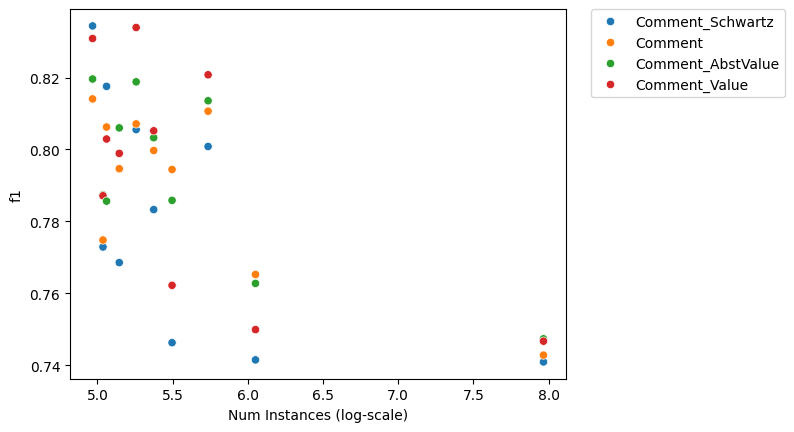

In [133]:
viz_llm_f1('Num Instances (log-scale)', author_to_numInst_log)

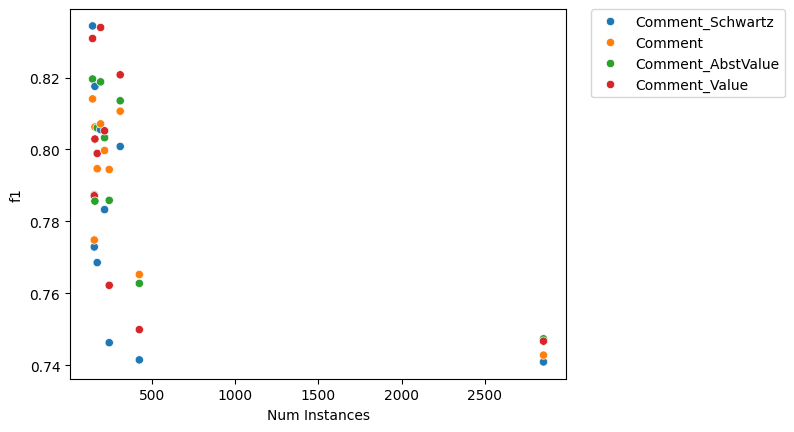

In [134]:
viz_llm_f1('Num Instances', author_to_numInst)

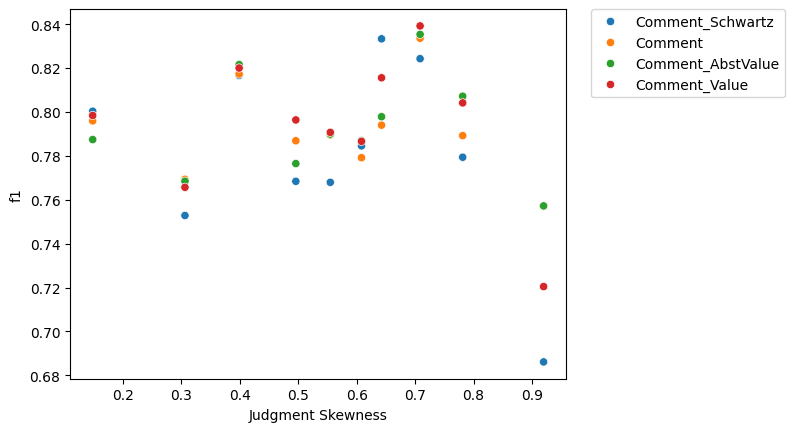

In [135]:
viz_llm_f1('Judgment Skewness', author_to_judgmentPatterns)

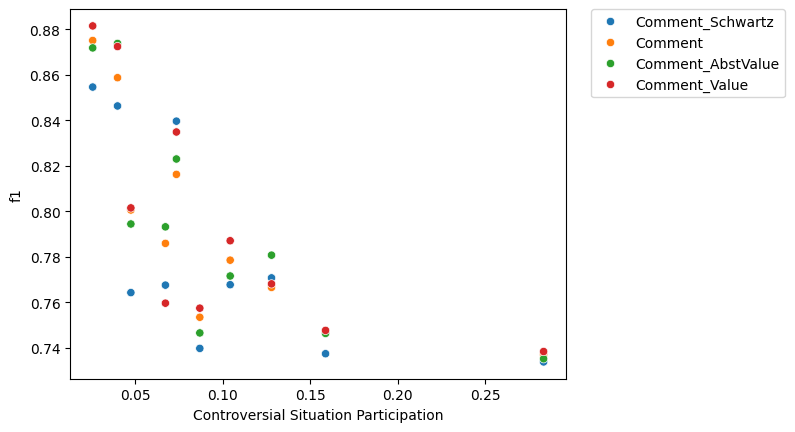

In [136]:
viz_llm_f1('Controversial Situation Participation', author_to_controversialRatio)

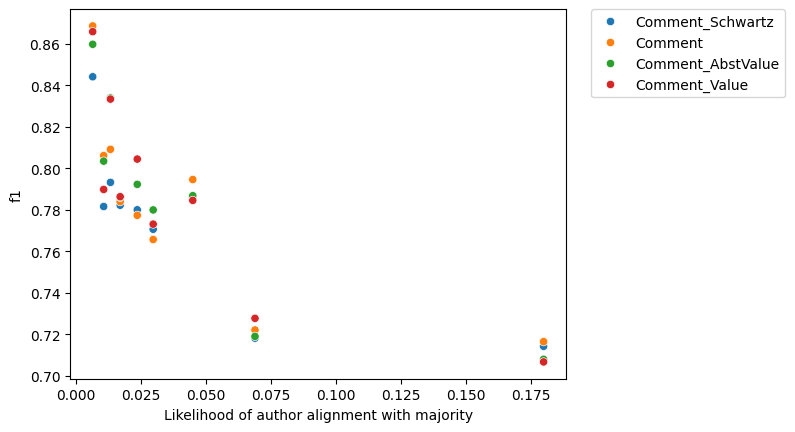

In [137]:
viz_llm_f1('Likelihood of author alignment with majority', author_to_majorityRatio)

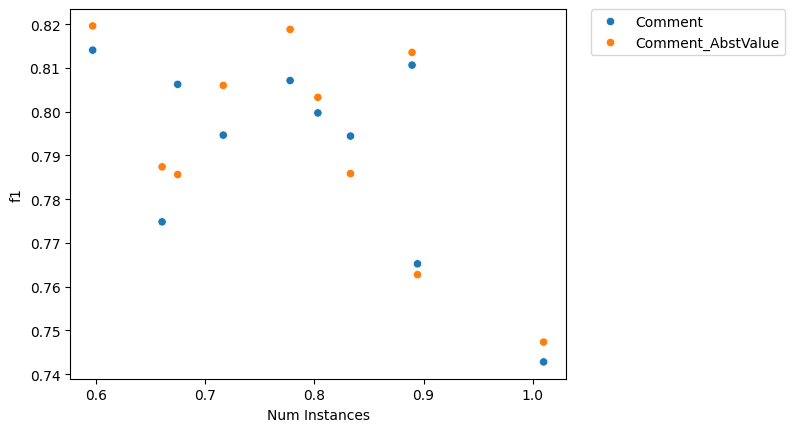

In [179]:
viz_llm_f1('Num Instances', author_to_numInst_flat, pass_list=[ "AbstValue", "Comment_Schwartz", "Comment_Value"])

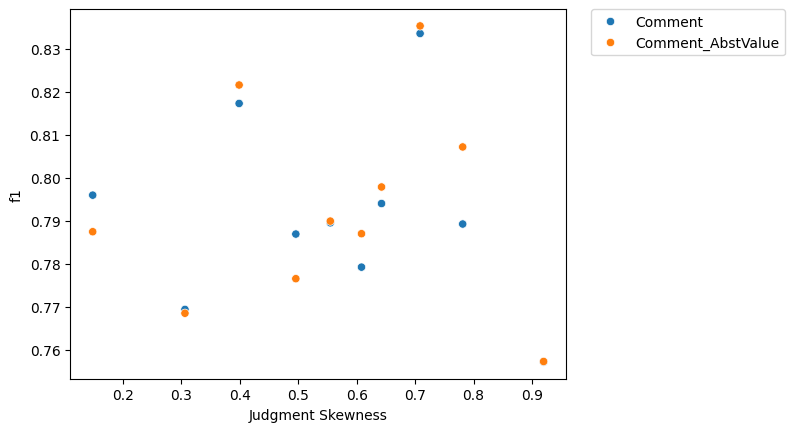

In [183]:
viz_llm_f1('Judgment Skewness', author_to_judgmentPatterns, pass_list=[ "AbstValue", "Comment_Schwartz", "Comment_Value"])

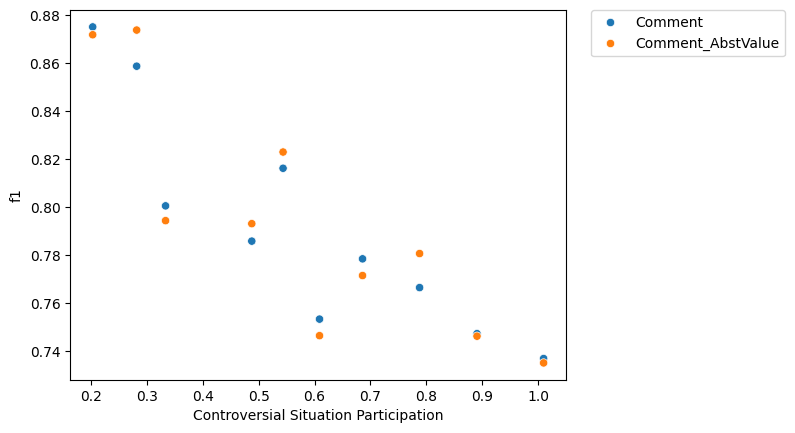

In [181]:
viz_llm_f1('Controversial Situation Participation', author_to_controversialRatio_flat, pass_list=[ "AbstValue", "Comment_Schwartz", "Comment_Value"])

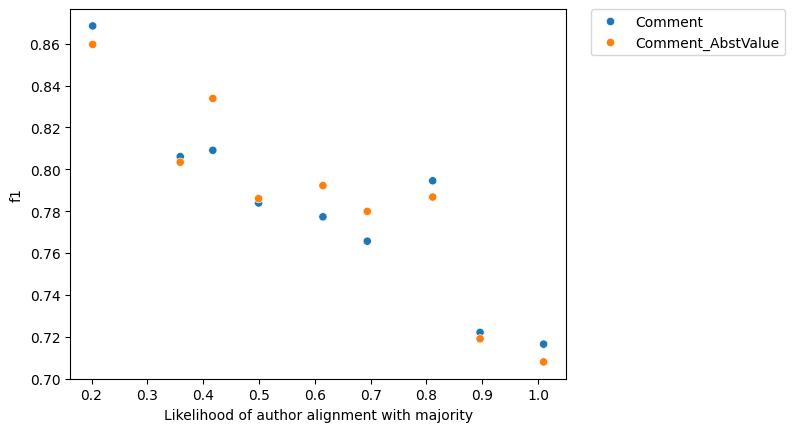

In [182]:
viz_llm_f1('Likelihood of author alignment with majority', author_to_majorityRatio_flat, pass_list=[ "AbstValue", "Comment_Schwartz", "Comment_Value"])

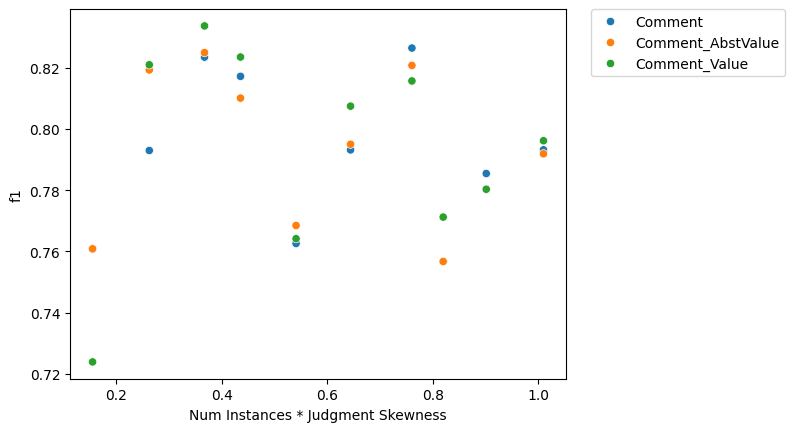

In [221]:
viz_llm_f1('Num Instances * Judgment Skewness', author_to_numInst_judgmentPatterns_flat, pass_list=[ "AbstValue", "Comment_Schwartz", ])

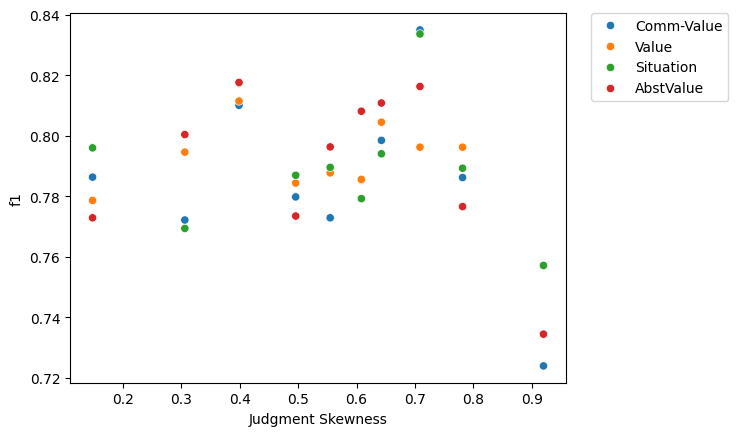

In [188]:
viz_llm_f1('Judgment Skewness', author_to_judgmentPatterns, fix='input', pass_list=['Schwartz',])

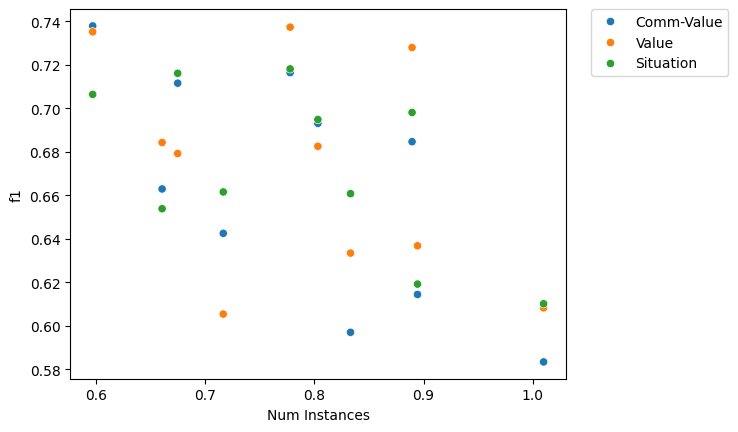

In [200]:
viz_llm_f1('Num Instances', author_to_numInst_flat, fix='input', pass_list=['Schwartz','AbstValue',], mode='minority')

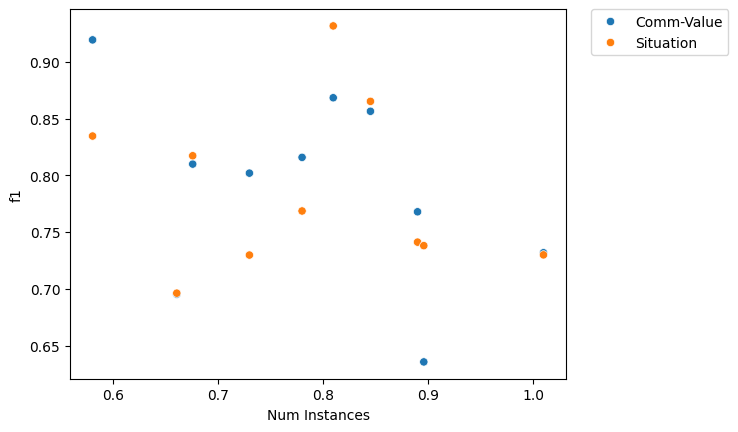

In [216]:
viz_llm_f1('Num Instances', author_to_numInst_flat, fix='input', pass_list=['Schwartz','AbstValue','Value'], isHard=True, )

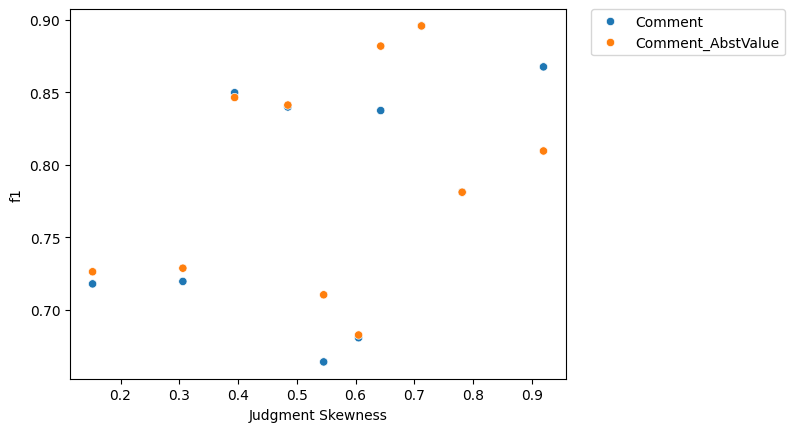

In [217]:
viz_llm_f1('Judgment Skewness', author_to_judgmentPatterns, pass_list=[ "AbstValue", "Comment_Schwartz", "Comment_Value"], isHard=True)
# viz_llm_f1('Num Instances', author_to_numInst_flat, fix='input', pass_list=['Schwartz','AbstValue','Value'], isHard=True, )

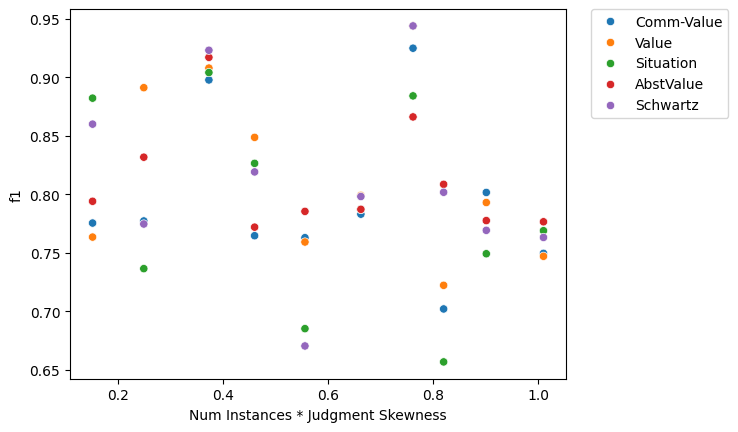

In [222]:
viz_llm_f1('Num Instances * Judgment Skewness', author_to_numInst_judgmentPatterns_flat, fix='input', isHard=True, )

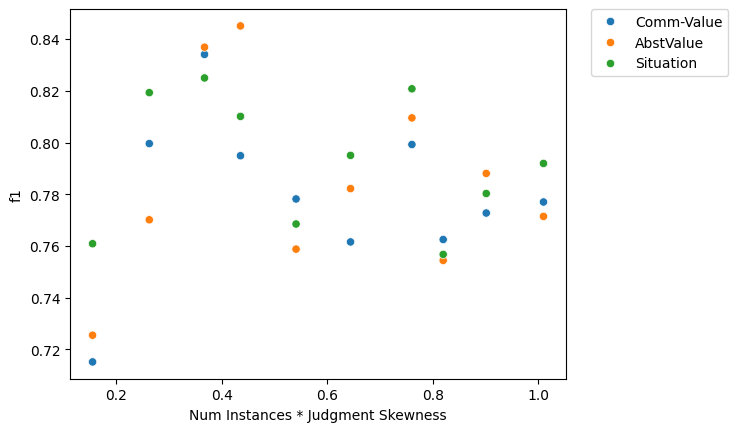

In [29]:
viz_llm_f1('Num Instances * Judgment Skewness', author_to_numInst_judgmentPatterns_flat, fix='input', pass_list=['Random'], input='Comment_AbstValue')

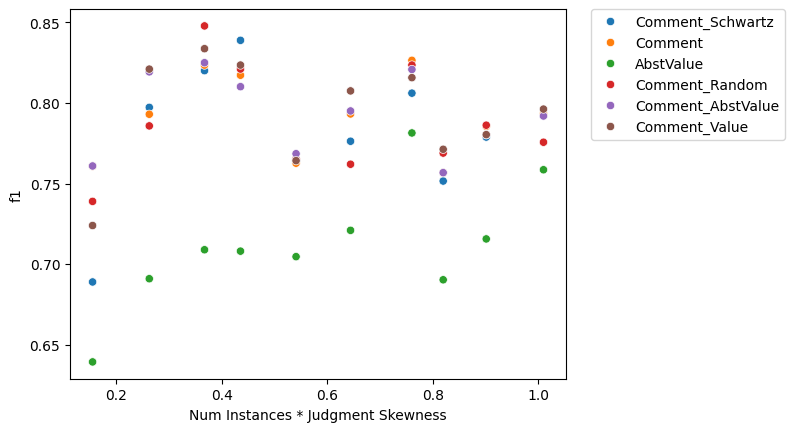

In [224]:
viz_llm_f1('Num Instances * Judgment Skewness', author_to_numInst_judgmentPatterns_flat )

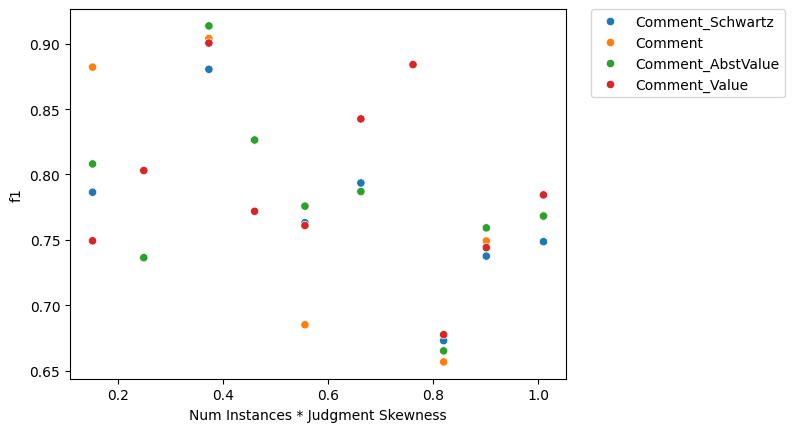

In [26]:
viz_llm_f1('Num Instances * Judgment Skewness', author_to_numInst_judgmentPatterns_flat, isHard=True, pass_list=['AbstValue'])

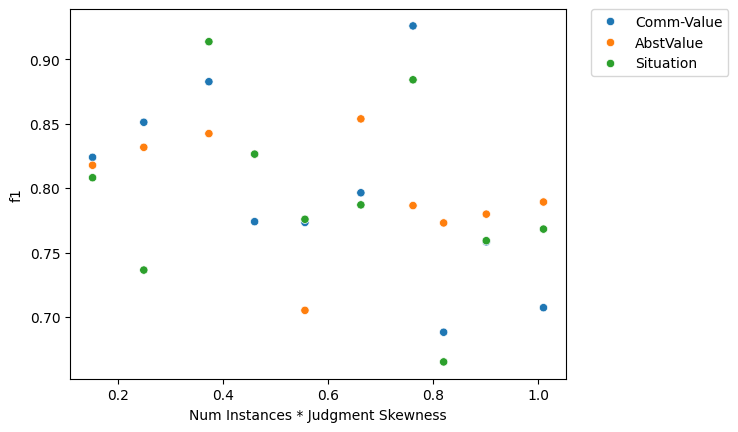

In [30]:
viz_llm_f1('Num Instances * Judgment Skewness', author_to_numInst_judgmentPatterns_flat, fix='input', pass_list=['Random'], input='Comment_AbstValue', isHard=True)